<a href="https://colab.research.google.com/github/Tilakraj-B/cardiac-disease/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose



In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset_path = "/content/drive/MyDrive/acdc_dataset.zip"  # Update this path
extract_folder = "/content/acdc_data"

In [9]:
# Step 3: Extract the dataset if not already extracted
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [10]:
def extract_cfg_values(file_path):
    config = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):  # Ignore empty lines and comments
                    if ':' in line:
                        key, value = line.split(':', 1)
                        config[key.strip()] = value.strip()
                    elif '=' in line:
                        key, value = line.split('=', 1)
                        config[key.strip()] = value.strip()
        return config
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

In [11]:
def load_nii_file(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    return data


In [12]:
# Step 5: Load and visualize a sample image (Modify the path based on extracted files)
base_dir = os.path.join(extract_folder,"database")
training_folder = os.path.join(extract_folder,"database","training")
testing_folder = os.path.join(extract_folder,"database","testing")
train_patients = [f'patient{i:03d}' for i in range(1, 100)]
test_patients = [f'patient{i:03d}' for i in range(1, 50)]

In [13]:
# Display all the images of a patient

def display_nifti_slices(nifti_path):
    nifti_img = nib.load(nifti_path)  # Load NIfTI file
    image_data = nifti_img.get_fdata()  # Convert to NumPy array

    print(f"\nDisplaying slices for {os.path.basename(nifti_path)}")
    print(f"Image shape: {image_data.shape}")  # Print shape

    dim = image_data.ndim  # Get number of dimensions
    if dim == 2:  # Case: 2D Image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_data, cmap="gray")
        plt.title(f"{os.path.basename(nifti_path)} - 2D Image")
        plt.axis("off")
        plt.show()

    elif dim == 3:  # Case: 3D Image (H, W, D)
        num_slices = image_data.shape[2]
        for i in range(num_slices):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_data[:, :, i], cmap="gray")
            plt.title(f"{os.path.basename(nifti_path)} - Slice {i+1}/{num_slices}")
            plt.axis("off")
            plt.show()

    elif dim == 4:  # Case: 4D Image (H, W, D, T)
        num_slices = image_data.shape[2]
        num_timeframes = image_data.shape[3]
        for t in range(num_timeframes):  # Loop over time
            for i in range(num_slices):  # Loop over depth
                plt.figure(figsize=(6, 6))
                plt.imshow(image_data[:, :, i, t], cmap="gray")
                plt.title(f"{os.path.basename(nifti_path)} - Time {t+1}/{num_timeframes} - Slice {i+1}/{num_slices}")
                plt.axis("off")
                plt.show()

    else:
        print(f"Unsupported image dimension: {dim}")

In [14]:
# Define a function to extract the ROI based on the ground truth mask
def extract_roi(image_slice, mask_slice, margin=10):
    # Find coordinates of the mask pixels
    coords = np.where(mask_slice > 0)
    if coords[0].size == 0 or coords[1].size == 0:
        # If no ROI found, return the original slices
        return image_slice, mask_slice

    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()

    # Add margin (ensuring we stay within image bounds)
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, image_slice.shape[0])
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, image_slice.shape[1])

    return image_slice[y_min:y_max, x_min:x_max], mask_slice[y_min:y_max, x_min:x_max]


In [15]:
def load_patient_data(patient_folder, es_or_ed):
    # Get all .nii files in the folder
    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES').zfill(2)
    ed = info.get('ED').zfill(2)
    if es_or_ed == 'ES':
      files = [f for f in os.listdir(patient_folder) if f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]
    elif es_or_ed == 'ED':
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii')]
    else :
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') or f.endswith(ed + '_gt.nii') or f.endswith(es + '.nii') or f.endswith(es + '_gt.nii')]

    # Separate image and ground truth files
    image_files = [f for f in files if not f.endswith('_gt.nii')]
    gt_files = [f for f in files if f.endswith('_gt.nii')]
    # print(patient_folder)
    # print(sorted(image_files))
    # print(sorted(gt_files))
    images = []
    masks = []
    height_scaling_factors = []
    width_scaling_factors = []
    roi_images = []
    roi_masks = []

    for img_file, gt_file in zip(sorted(image_files), sorted(gt_files)):
        img_data = load_nii_file(os.path.join(patient_folder, img_file))
        gt_data = load_nii_file(os.path.join(patient_folder, gt_file))

        #iterating through each slice in the model
        for slice_idx in range(img_data.shape[2]):
            img_slice = img_data[..., slice_idx]
            gt_slice = gt_data[..., slice_idx]

            # Normalize and resize if needed
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())

            # ROI Extraction Step
            img_slice, gt_slice = extract_roi(img_slice, gt_slice, margin=10)
            roi_images.append(img_slice)
            roi_masks.append(gt_slice)
            # Calculate scaling factors
            roi_height, roi_width = img_slice.shape

        # Compute scaling factors based on the ROI dimensions and the target resize dimensions
            height_scale = roi_height / 256  # vertical scaling factor
            width_scale = roi_width / 256   # horizontal scaling factor


            height_scaling_factors.append(height_scale)
            width_scaling_factors.append(width_scale)

            # Resize to make dimensions divisible by 16 for U-Net (optional)
            img_slice = tf.image.resize(img_slice[..., np.newaxis], [256, 256], method='bilinear')
            gt_slice = tf.image.resize(gt_slice[..., np.newaxis], [256, 256], method='nearest')
            images.append(img_slice.numpy())
            masks.append(gt_slice.numpy())

    return  np.array(images), np.array(masks), roi_images,roi_masks, height_scaling_factors, width_scaling_factors




In [16]:
def load_dataset(root_folder, patient_range):
    all_images = []
    all_masks = []

    for patient_id in patient_range:
        patient_folder = os.path.join(root_folder, f"patient{patient_id:03d}")
        if os.path.exists(patient_folder):
            images, masks, _, _, _,_ = load_patient_data(patient_folder , 'EDES')
            all_images.extend(images)
            all_masks.extend(masks)

    return np.array(all_images), np.array(all_masks)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
train_images, train_masks = load_dataset(training_folder, range(1, 101))

In [18]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path (Decoder)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [19]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [20]:
def train_model():
    # Load training data
    train_images, train_masks = load_dataset(training_folder, range(1, 101))

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )

        # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator = datagen.flow(X_train, y_train, batch_size=16)

    # Create model
    model = unet()
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]

    # Train
    history = model.fit(
        train_generator,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=100,
        callbacks=callbacks
    )

    return model, history

In [21]:
def apply_kmeans_with_filters(segmented_image, k=3):

    # Apply Gaussian smoothing filter
    smoothed_image = cv2.GaussianBlur(segmented_image, (5, 5), 0)

    # Define a sharpening kernel and apply it
    kernel_sharpening = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(smoothed_image, -1, kernel_sharpening)

    # Flatten the sharpened image for clustering
    flat_image = sharpened_image.reshape(-1, 1)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(flat_image)

    # Reshape the cluster labels back to the original image shape
    clustered = kmeans.labels_.reshape(segmented_image.shape)
    return clustered, smoothed_image, sharpened_image


In [33]:
def evaluate_model(model):
    # Load test data
    test_images, test_masks = load_dataset(testing_folder, range(101, 151))  # Assuming test data range is 101-150

    # Evaluate
    results = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

    # Predict
    predicted_mask = model.predict(test_images[:10])



    plt.figure(figsize=(20, 10))
    for i in range(10):
        original_image = test_images[i].squeeze()
        true_mask = test_masks[i].squeeze()
        pred_mask = predicted_mask[i].squeeze()  # Binary mask

        # Extract predicted region
        # segmented_image = original_image * pred_mask  # Element-wise multiplication


        plt.subplot(7, 10, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Input')
        plt.axis('off')

        plt.subplot(7, 10, i + 11)
        plt.imshow(true_mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(7, 10, i + 21)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Prediction Mask')
        plt.axis('off')

        # plt.subplot(7, 10, i + 31)
        # plt.imshow(segmented_image, cmap='gray')
        # plt.title('Segmented Region')
        # plt.axis('off')

        # # Plot K-means Clustering Result (3 regions)
        # plt.subplot(7, 10, i + 41)
        # plt.imshow(kmeans_clusters, cmap='jet')
        # plt.title('K-means Clusters')
        # plt.axis('off')

        # plt.subplot(7, 10, i + 51)
        # plt.imshow(smoothed_image, cmap='jet')
        # plt.title('K-means Clusters')
        # plt.axis('off')

        # plt.subplot(7, 10, i + 61)
        # plt.imshow(sharpened_image, cmap='jet')
        # plt.title('K-means Clusters')
        # plt.axis('off')


    plt.tight_layout()
    plt.show()


In [23]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


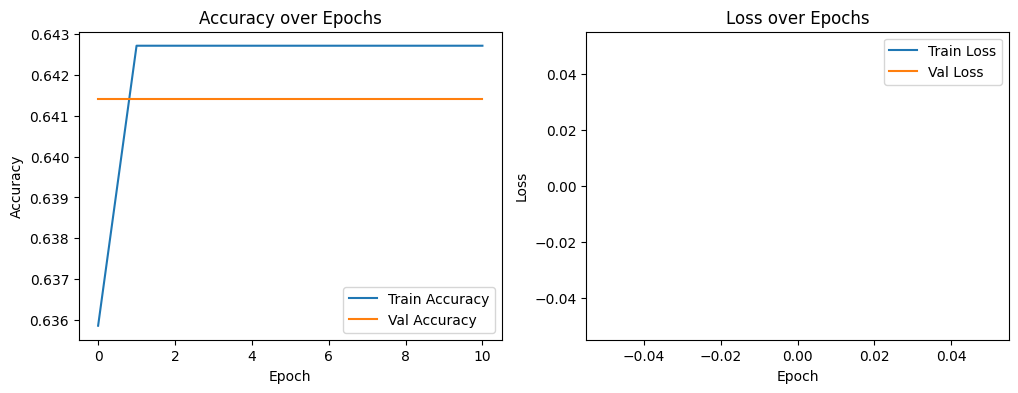

In [27]:
import json

if not os.path.exists('unet_mri_segmentation.keras'):
    model, history = train_model()

    # Save model
    model.save('unet_mri_segmentation.keras')

    # Save training history
    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    plot_training_history(history)
else:
    model = tf.keras.models.load_model('unet_mri_segmentation.keras')

    # Load training history if needed
    if os.path.exists('training_history.json'):
        with open('training_history.json', 'r') as f:
            history_data = json.load(f)

        # Create a dummy History object if needed
        class DummyHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        history = DummyHistory(history_data)
        plot_training_history(history)


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step - accuracy: 0.6647 - loss: nan
Test Loss: nan, Test Accuracy: 0.6649393439292908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


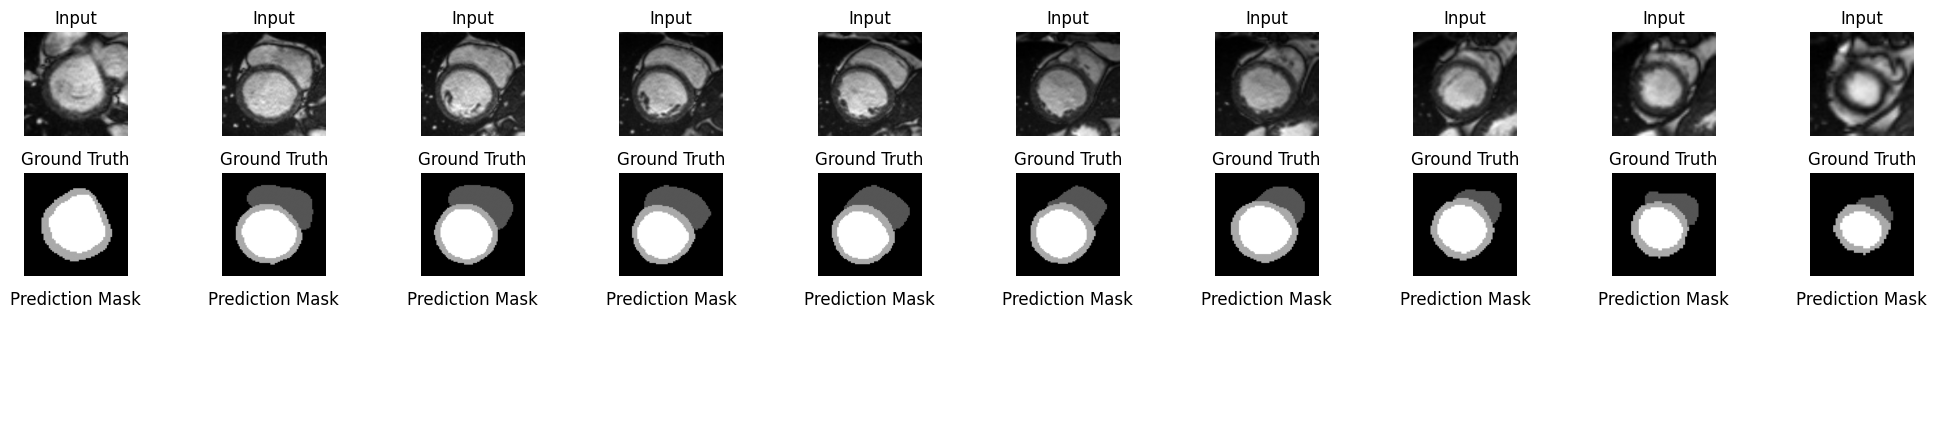

In [34]:
    # Evaluate on test set
    evaluate_model(model)

In [35]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice coefficient."""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


In [36]:
def resize_predicted_masks(predicted_masks, height_scaling_factors, width_scaling_factors, original_base_size=(224, 256)):
    original_masks_resized = []

    for j in range(predicted_masks.shape[0]):
        original_height = int(original_base_size[0] * height_scaling_factors[j]) if height_scaling_factors[j] > 0 else original_base_size[0]
        original_width = int(original_base_size[1] * width_scaling_factors[j]) if width_scaling_factors[j] > 0 else original_base_size[1]

        rescaled_mask = tf.image.resize(predicted_masks[j], [original_height, original_width], method='nearest')
        original_masks_resized.append(rescaled_mask)
    return original_masks_resized

In [ ]:
def eval():
  dice_scores_ed = []
  dice_scores_es = []

  for i in range(101, 151):
    patient_folder = os.path.join(testing_folder, f"patient{i:03d}")

    ED_test_images, ED_test_masks,ED_test_images_roi, ED_test_masks_roi,ED_height_scaling_factors, ED_width_scaling_factors = load_patient_data(patient_folder , 'ED')
    ES_test_images, ES_test_masks,ES_test_images_roi, ES_test_masks_roi,ES_height_scaling_factors, ES_width_scaling_factors = load_patient_data(patient_folder , 'ES')

    ED_predicted_mask = model.predict(ED_test_images)
    ES_predicted_mask = model.predict(ES_test_images)

    ED_predicted_mask_resized = resize_predicted_masks(
        predicted_masks=ED_predicted_mask,
        height_scaling_factors=ED_height_scaling_factors,
        width_scaling_factors=ED_width_scaling_factors
    )

    ES_predicted_mask_resized = resize_predicted_masks(
        predicted_masks=ES_predicted_mask,
        height_scaling_factors=ES_height_scaling_factors,
        width_scaling_factors=ES_width_scaling_factors
    )


    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES').zfill(2)
    ed = info.get('ED').zfill(2)

    ED_file = os.path.join(patient_folder,f"patient{i:03d}_frame{ed}.nii")
    ES_file = os.path.join(patient_folder,f"patient{i:03d}_frame{es}.nii")


      # Generate segmented images for ED
    ED_segmented_images = []
    for j in range(len(ED_predicted_mask_resized)):
            # Convert tensor to numpy array and threshold
            mask_np = ED_predicted_mask_resized[j].numpy().squeeze()
            binary_mask = (mask_np > 0.7).astype(np.float32)
            # Get corresponding ROI image
            roi_img = ED_test_images_roi[j]

            if binary_mask.shape != roi_img.shape[:2]:  # Compare only spatial dims
                binary_mask = tf.image.resize(
                    binary_mask[..., np.newaxis],  # Add channel dim for TF
                    roi_img.shape[:2],  # Target shape (H, W)
                    method='nearest'
                ).numpy().squeeze()

            # Apply mask to ROI image
            segmented = roi_img * binary_mask
            ED_segmented_images.append(segmented)


            plt.figure(figsize=(12, 4))

            # Input Image (ROI)
            plt.subplot(1, 4, 1)
            plt.imshow(roi_img.squeeze(), cmap='gray')
            plt.title(f"Input Image (Patient {i}, ED Frame {j}")
            plt.axis('off')

            # Ground Truth Image
            plt.subplot(1, 4, 2)
            plt.imshow(ED_test_masks_roi[j].squeeze(), cmap='gray')
            plt.title("Ground Truth Image")
            plt.axis('off')





        # Generate segmented images for ES (similar to ED)
    ES_segmented_images = []
    for j in range(len(ES_predicted_mask_resized)):
            mask_np = ES_predicted_mask_resized[j].numpy().squeeze()
            binary_mask = (mask_np > 0.5).astype(np.float32)
            roi_img = ES_test_images_roi[j]

            if binary_mask.shape != roi_img.shape[:2]:  # Compare only spatial dims
                binary_mask = tf.image.resize(
                    binary_mask[..., np.newaxis],  # Add channel dim for TF
                    roi_img.shape[:2],  # Target shape (H, W)
                    method='nearest'
                ).numpy().squeeze()

            segmented = roi_img * binary_mask

            ES_segmented_images.append(segmented)

            plt.figure(figsize=(12, 4))

            # Input Image (ROI)
            plt.subplot(1, 5, 1)
            plt.imshow(roi_img.squeeze(), cmap='gray')
            plt.title(f"Input Image (Patient {i}, ES Frame {j}")
            plt.axis('off')

            # Ground Truth Image
            plt.subplot(1, 5, 2)
            plt.imshow(ES_test_masks_roi[j].squeeze(), cmap='gray')
            plt.title("Ground Truth Image")
            plt.axis('off')
            # Predicted Mask (Binary)
            plt.subplot(1, 5, 3)
            plt.imshow(binary_mask.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            # Segmented Image (Mask Applied)
            plt.subplot(1, 5, 4)
            plt.imshow(segmented.squeeze(), cmap='gray')
            plt.title("Segmented Image")
            plt.axis('off')



            plt.tight_layout()
            plt.show()






In [ ]:
eval()